# Pneumonia Detection

This purpose of this notebook is to build a model that is proficient at detecting pneumonia given x-ray images. The data was taken from Kaggle and has three different folders, each with two classes: there is a test, train, and validation folder that has images of class NORMAL and PNEUMONIA. While the x-ray images look grayscale, they are stil 3 channel and need to be treated as such in order for the model to work properly.

The validation folder only housed about a total of 16 images between both NORMAL and PNEUMONIA classes. As such, I decided to move approximately 84 images from the train set over to the validation set. This resulted in 5040 images in the train folder, 624 images in the test folder, and 192 images in the validation folder. There was also an imbalance in the classes, with the PNEUMONIA class having almost 3 times as many instances as the NORMAl class in the train folder. To combat this, data augmentation was randomly done to images during training. 

Initially the models were custom made, with the make up of layers and the number of layers determined by me. The first 3 models were custom, which performed well, but were still overfitting on the training set. Ultimately, for the 4th model, VGG16 was used with imagenet weights and that performed the best, with validation accuracy and train accuracy being very close to one another. Each model was evaluated against the validation set while it trained and ultimately evaluated against the test set. Each model had graphs that modeled the accuracy and loss across each epoch, which made it easy to determine which ones performed well and which ones didn't. 

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.regularizers import L2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
#import cv2
from collections import Counter
import efficientnet.keras as efn

We will load all the images from the train, val, and test folders. With flow_from_directory, the images will have the labels attached so we do not need to specify the labels.

I have also moved some of the train images into the val folder since there was a pretty large imbalance. There were only around 10 images in the validation set.

In [8]:
#Change batch size depending on scenario
b_size = 32 

train_data = ImageDataGenerator(rescale=1/255)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(224,224), batch_size=b_size, class_mode='binary', shuffle=True)
#train_labels = to_categorical(train_img.labels, num_classes=2)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)
#val_labels = to_categorical(val_img.labels, num_classes=2)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)
#test_labels = to_categorical(test_img.labels, num_classes=2)
print(train_img.class_indices)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


In [43]:
counter_train = Counter(train_img.classes)
counter_val = Counter(val_img.classes)
counter_test = Counter(test_img.classes)

normal = counter_train[0] + counter_val[0] + counter_test[0]
pneumonia = counter_train[1] + counter_val[1] + counter_test[1]
print(f'Normal: {normal}\nPneumonia: {pneumonia}')

Normal: 1583
Pneumonia: 4273


After tinkering with the data, it seems that include 'class_mode=binary' in the flow from directory function caused the model to work properly. Without it, the test accuracy and validation accuracy was exactly 0.5 for each epoch.

# Custom Model 1
Here we will make a pretty shallow network to see how well it will work. Despite the images looking like grayscale, they are still 3 channel(rgb).

In [9]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3), groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_hist = model.fit(train_img, 
                       epochs=10, 
                       validation_data=val_img, 
                       steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 36s 240ms/step - loss: 0.4548 - accuracy: 0.9404 - val_loss: 24.0668 - val_accuracy: 0.5000
Epoch 2/10
150/150 [==============================] - 35s 235ms/step - loss: 0.0612 - accuracy: 0.9797 - val_loss: 4.7419 - val_accuracy: 0.5052
Epoch 3/10
150/150 [==============================] - 35s 235ms/step - loss: 0.0451 - accuracy: 0.9818 - val_loss: 3.0555 - val_accuracy: 0.5104
Epoch 4/10
150/150 [==============================] - 35s 233ms/step - loss: 0.0331 - accuracy: 0.9883 - val_loss: 3.6355 - val_accuracy: 0.5625
Epoch 5/10
150/150 [==============================] - 35s 232ms/step - loss: 0.0203 - accuracy: 0.9925 - val_loss: 5.0653 - val_accuracy: 0.5833
Epoch 6/10
150/150 [==============================] - 35s 234ms/step - loss: 0.0220 - accuracy: 0.9895 - val_loss: 0.1505 - val_accuracy: 0.9583
Epoch 7/10
150/150 [==============================] - 35s 236ms/step - loss: 0.0521 - accuracy: 0.9866 - val_loss: 62.6565 - val_

When we evaluate on the test set, we see that the accuracy is not too great, sitting at just above 60 percent.

In [11]:
model.evaluate(test_img)

20/20 [==============================] - 9s 433ms/step - loss: 6.6874 - accuracy: 0.6346


[6.687426567077637, 0.6346153616905212]

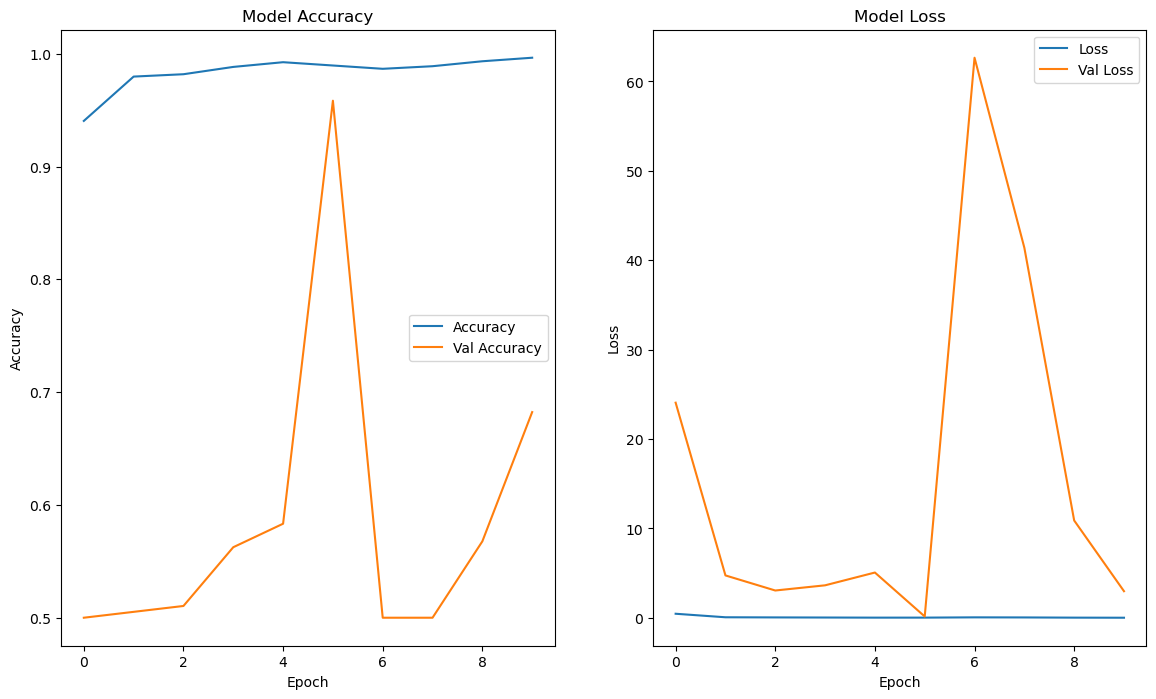

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(14, 8))

ax1.plot(model_hist.history['accuracy'])
ax1.plot(model_hist.history['val_accuracy'])
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2.plot(model_hist.history['loss'])
ax2.plot(model_hist.history['val_loss'])
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch');

When we graph the results, we can see that the accuracy is all over the place. While the model is getting good accuracy on the train set, it is overfitting incredibly hard. The validation accuracy is considerably lower than than the train accuracy, save for one epoch where it randomly spiked up.


# Custom Model 2
We will try to fix this and improve the test accuracy by adding deeper layers. We will also bath normalize and add dropout to the layers.

I will also augment some of the images when we pull them in to prevent overfitting and potentially help more with the imbalance in the data

In [17]:
#Change batch size depending on scenario
b_size = 32 

train_data = ImageDataGenerator(rescale=1/255, rotation_range=30, zoom_range=0.2, horizontal_flip=True,
                                width_shift_range=0.2, height_shift_range=0.2)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(224,224), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(224, 224), batch_size=b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3), groups=1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', groups=1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', groups=1))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(units=1, activation='sigmoid'))

We will monitor the accuracy and decrease learning rate if the accuracy plateaus. We will also start with a lower learning rate to start off with to see if the model will learn better.

In [19]:
optimizer = keras.optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=4)

model2.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model2_hist = model2.fit(train_img, epochs=10, validation_data=val_img, steps_per_epoch=5040/b_size, callbacks=[reduce_lr, early_stop])

c:\Users\Eddie\anaconda3\envs\gpuenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
157/157 [==============================] - 72s 454ms/step - loss: 0.3487 - accuracy: 0.8611 - val_loss: 10.4938 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/10
157/157 [==============================] - 71s 446ms/step - loss: 0.2403 - accuracy: 0.9018 - val_loss: 14.9434 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/10
157/157 [==============================] - 71s 449ms/step - loss: 0.2212 - accuracy: 0.9060 - val_loss: 13.9552 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/10
157/157 [==============================] - 71s 447ms/step - loss: 0.1873 - accuracy: 0.9212 - val_loss: 3.7604 - val_accuracy: 0.5000 - lr: 2.0000e-05
Epoch 5/10
157/157 [==============================] - 71s 449ms/step - loss: 0.1727 - accuracy: 0.9302 - val_loss: 0.4335 - val_accuracy: 0.9062 - lr: 2.0000e-05
Epoch 6/10
157/157 [==============================] - 71s 449ms/step - loss: 0.1747 - accuracy: 0.9308 - val_loss: 0.2513 - val_accuracy: 0.9062 - lr: 2.0000e-05
Epoch 7/10
157/157 [=====

In [20]:
model2.evaluate(test_img)

20/20 [==============================] - 4s 193ms/step - loss: 0.3320 - accuracy: 0.8782


[0.3319860100746155, 0.8782051205635071]

Here we can see that the model is performing considerably better, but it still isn't doing the best job at generalizing: there is still a little bit of overfitting. We will still try to prevent this.

Text(0.5, 1.0, 'Model Loss')

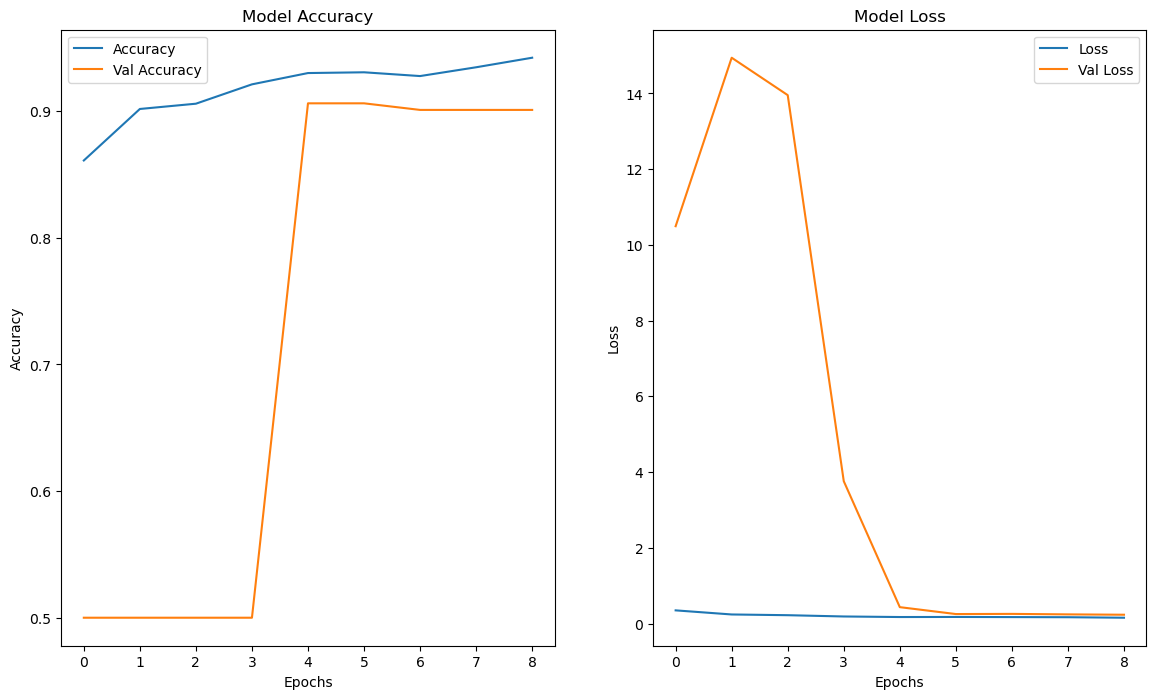

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model2_hist.history['accuracy'])
ax1.plot(model2_hist.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')

ax2.plot(model2_hist.history['loss'])
ax2.plot(model2_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# Custom Model 3
While the performance has increased, we can see there is still some overfitting. It is also not quite clear why the validation accuracy is stagnant for the first 3 epochs, and the validation loss skyrockets during the first 1-2 epochs. 

What I will try next is to add more regularization and more data augmentation to help with overfitting. The images will also be scaled down to 150x150 to potentially help with learning speed.

In [49]:
#Change batch size depending on scenario
b_size = 16

train_data = ImageDataGenerator(rescale=1/255, rotation_range=35, zoom_range=0.25, horizontal_flip=True,
                                width_shift_range=0.25, height_shift_range=0.25)
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(150,150), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(150, 150), batch_size=b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(150, 150), batch_size=b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


We will increase the dropout layers, and add a kernel regularizer to the dense function.

In [50]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3), groups=1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', groups=1))
model3.add(Dropout(0.1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', groups=1))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', groups=1))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model3.add(GlobalAveragePooling2D())
model3.add(Dense(units=64, activation='relu', kernel_regularizer=L2(0.01)))
model3.add(Dropout(0.4))
model3.add(Dense(units=1, activation='sigmoid'))

There are a few more things we are doing here. Clipnorm is being added to the Adam optimizer to prevent the gradient from exploding. The batch size has also been decreased so that there are more steps per epoch.

In [51]:
optimizer = keras.optimizers.Adam(lr=0.0001, clipnorm=1.0)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=1, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True , patience=3, verbose=1)

model3.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])
with tf.device('/GPU:0'): #Don't think this is working properly, needs at least python 3.9
    model3_hist = model3.fit(train_img, 
                             epochs=10, 
                             validation_data=val_img, 
                             steps_per_epoch= 5040/b_size, 
                             callbacks=[reduce_lr, early_stop])

c:\Users\Eddie\anaconda3\envs\gpuenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
315/315 [==============================] - 71s 221ms/step - loss: 1.1049 - accuracy: 0.8397 - recall_15: 0.8978 - val_loss: 2.9411 - val_accuracy: 0.5000 - val_recall_15: 1.0000 - lr: 1.0000e-04
Epoch 2/10
315/315 [==============================] - 60s 192ms/step - loss: 0.8919 - accuracy: 0.8724 - recall_15: 0.9179 - val_loss: 1.0190 - val_accuracy: 0.8125 - val_recall_15: 0.9688 - lr: 1.0000e-04
Epoch 3/10
315/315 [==============================] - 61s 193ms/step - loss: 0.7584 - accuracy: 0.8873 - recall_15: 0.9253 - val_loss: 0.7863 - val_accuracy: 0.8646 - val_recall_15: 0.7917 - lr: 1.0000e-04
Epoch 4/10
315/315 [==============================] - 60s 191ms/step - loss: 0.6557 - accuracy: 0.9022 - recall_15: 0.9414 - val_loss: 0.7062 - val_accuracy: 0.8802 - val_recall_15: 0.8438 - lr: 1.0000e-04
Epoch 5/10
315/315 [==============================] - ETA: 0s - loss: 0.5769 - accuracy: 0.9079 - recall_15: 0.9390
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.99999

In [52]:
model3.evaluate(test_img)

39/39 [==============================] - 5s 121ms/step - loss: 0.6268 - accuracy: 0.8734 - recall_15: 0.9231


[0.6267778873443604, 0.8733974099159241, 0.9230769276618958]

Text(0.5, 1.0, 'Model Loss')

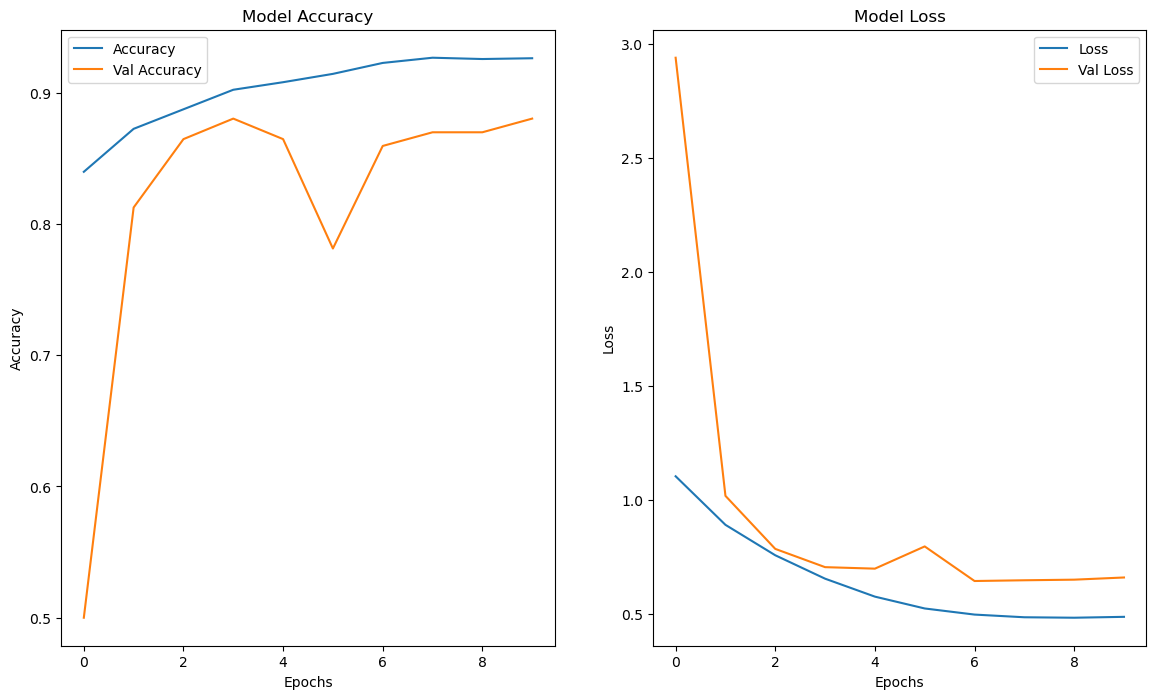

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model3_hist.history['accuracy'])
ax1.plot(model3_hist.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy'])
ax1.set_title('Model Accuracy')

ax2.plot(model3_hist.history['loss'])
ax2.plot(model3_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

Unfortunately, even with all these changes, the model does not seem to be getting better at generalizing. There is still a sizeable gap between train and validation accuracy.

# VGG16
Now that a wall has been hit with my own model, I will explore using other models that have already been trained and perform extremely well. 

First, starting with VGG16. It turns out that adam optimizer does not work well with VGG16 so we will use SGD. For this model, we will also look at recall score since a false negative is pretty bad (diagnosed normal but has pneumonia).

In [132]:
#Change batch size depending on scenario
b_size =  16

train_data = ImageDataGenerator(rescale=1/255, rotation_range=30, zoom_range=0.2, horizontal_flip=True,
                                width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest') #CHANGED FILL_MODE TO CONSTANT TO TEST MODEL, DEFAULT=NEAREST
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(150,150), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(150, 150), batch_size = b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(150, 150), batch_size = b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [25]:
model4 = Sequential()
model4.add(VGG16(include_top = False, pooling='max', weights='imagenet', input_shape=(150, 150, 3)))

model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=1, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True , patience=3, verbose=1)

optimizer = keras.optimizers.SGD(lr=0.0001, clipnorm=1.0)
model4.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])

In [8]:
model4_hist = model4.fit(train_img, epochs=15, validation_data=val_img, steps_per_epoch=5040/b_size, callbacks=[early_stop])

Epoch 1/15
315/315 [==============================] - 54s 168ms/step - loss: 0.5674 - accuracy: 0.7419 - recall_1: 0.9786 - val_loss: 0.7083 - val_accuracy: 0.5000 - val_recall_1: 1.0000
Epoch 2/15
315/315 [==============================] - 51s 163ms/step - loss: 0.4972 - accuracy: 0.7534 - recall_1: 0.9997 - val_loss: 0.6415 - val_accuracy: 0.5156 - val_recall_1: 1.0000
Epoch 3/15
315/315 [==============================] - 51s 163ms/step - loss: 0.4404 - accuracy: 0.7734 - recall_1: 0.9976 - val_loss: 0.5354 - val_accuracy: 0.6094 - val_recall_1: 1.0000
Epoch 4/15
315/315 [==============================] - 52s 165ms/step - loss: 0.3934 - accuracy: 0.8058 - recall_1: 0.9884 - val_loss: 0.4167 - val_accuracy: 0.8281 - val_recall_1: 0.9792
Epoch 5/15
315/315 [==============================] - 51s 163ms/step - loss: 0.3376 - accuracy: 0.8508 - recall_1: 0.9723 - val_loss: 0.3270 - val_accuracy: 0.8906 - val_recall_1: 0.9583
Epoch 6/15
315/315 [==============================] - 52s 166ms/s

# Trainable layers set to False

In [7]:
#Change batch size depending on scenario
b_size =  16

train_data = ImageDataGenerator(rescale=1/255, rotation_range=30, zoom_range=0.2, horizontal_flip=True,
                                width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest') #CHANGED FILL_MODE TO CONSTANT TO TEST MODEL, DEFAULT=NEAREST
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(150,150), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(150, 150), batch_size = b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(150, 150), batch_size = b_size, class_mode='binary', shuffle=True)

modelt = Sequential()
modelt.add(VGG16(include_top = False, pooling='max', weights='imagenet', input_shape=(150, 150, 3)))

modelt.add(Flatten())
modelt.add(Dense(128, activation='relu'))
modelt.add(Dense(1, activation='sigmoid'))
modelt.layers[0].trainable = False

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=1, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True , patience=10, verbose=1)

optimizer = keras.optimizers.SGD(lr=0.001, clipnorm=1.0)
modelt.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])

modelt_hist = modelt.fit(train_img, epochs=15, validation_data=val_img, steps_per_epoch=5040/b_size, callbacks=[early_stop])

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/15
315/315 [==============================] - 54s 169ms/step - loss: 0.5640 - accuracy: 0.7129 - recall_4: 0.9073 - val_loss: 0.7721 - val_accuracy: 0.5000 - val_recall_4: 1.0000
Epoch 2/15
315/315 [==============================] - 52s 166ms/step - loss: 0.4992 - accuracy: 0.7514 - recall_4: 0.9997 - val_loss: 0.6894 - val_accuracy: 0.5000 - val_recall_4: 1.0000
Epoch 3/15
315/315 [==============================] - 53s 167ms/step - loss: 0.4658 - accuracy: 0.7540 - recall_4: 0.9995 - val_loss: 0.6531 - val_accuracy: 0.5208 - val_recall_4: 1.0000
Epoch 4/15
315/315 [==============================] - 53s 169ms/step - loss: 0.4400 - accuracy: 0.7635 - recall_4: 0.9960 - val_loss: 0.5936 - val_accuracy: 0.5677 - val_recall_4: 1.0000
Epoch 5/15
315/315 [==============================] - 54s 171ms/step - loss: 0.4207 - accuracy: 0.7796 - recall_4: 0.9926 - val_

In [9]:
model4.evaluate(test_img)

39/39 [==============================] - 4s 98ms/step - loss: 0.2678 - accuracy: 0.8910 - recall_1: 0.9385


[0.267839640378952, 0.8910256624221802, 0.9384615421295166]

We see from the charts and the numbers that this is the best performing model, not by much, but still better. The accuracy is higher and the validation accuracy and train accuracy are very similar so there is no overfitting. The recall score is also pretty high, which is good. This final model will be the one to present.

Text(0.5, 1.0, 'Model Loss')

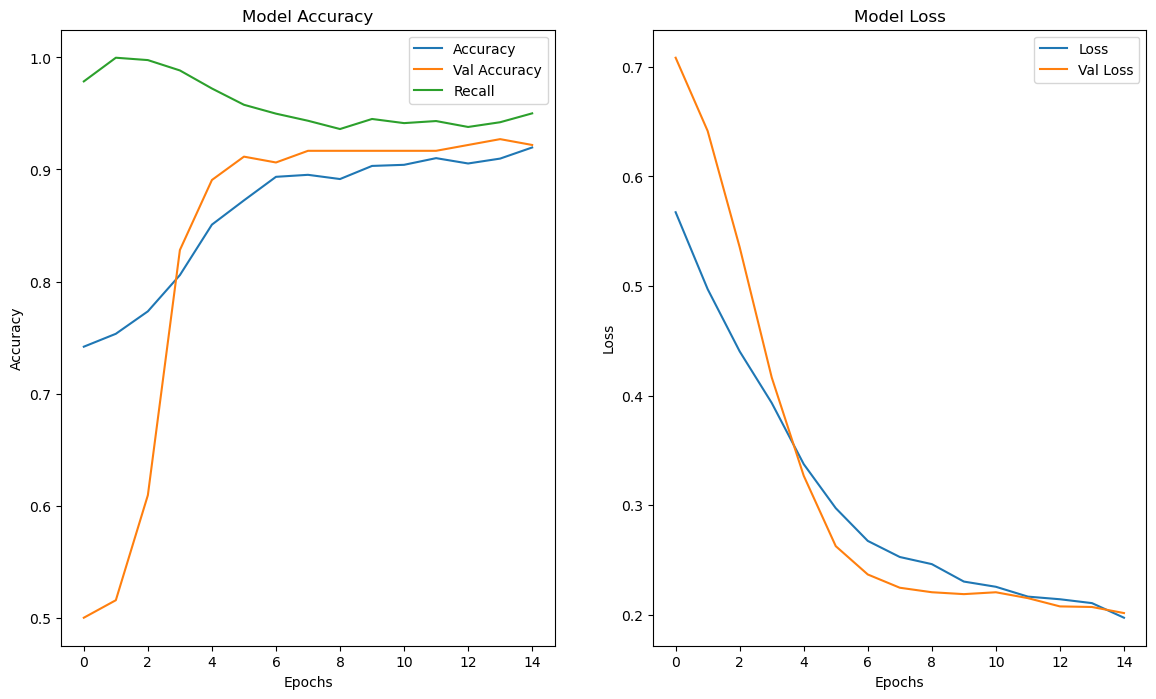

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model4_hist.history['accuracy'])
ax1.plot(model4_hist.history['val_accuracy'])
#ax1.plot(model4_hist.history['recall_1'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy', 'Recall'])
ax1.set_title('Model Accuracy')

ax2.plot(model4_hist.history['loss'])
ax2.plot(model4_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# Resnet50
Here we will try another popular neural network known as ResNet. It is deeper than VGG16 and is generally better at dealing with vanishing gradients.

In [25]:
#Change batch size depending on scenario
b_size = 16

#train_data = ImageDataGenerator(rescale=1/255, rotation_range=35, zoom_range=0.3, horizontal_flip=True,
#                                width_shift_range=0.25, height_shift_range=0.25, fill_mode='nearest' ) #CHANGED FILL_MODE TO CONSTANT TO TEST MODEL, DEFAULT=NEAREST
train_data = ImageDataGenerator(rescale=1/255, rotation_range=10, zoom_range=0.1, horizontal_flip=True,
                                width_shift_range=0.1, height_shift_range=0.1, fill_mode='nearest' )
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(150,150), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(150, 150), batch_size = b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(150, 150), batch_size = b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Setup is pretty much identical to vgg16, except this model had the trainable layers set to false.

In [26]:
model5 = Sequential()
model5.add(ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3), pooling='max'))

model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))
model5.layers[0].trainable = False

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True , patience=5, verbose=1)

optimizer = keras.optimizers.Adam(lr=0.0001, clipnorm=1.0)
model5.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])

In [27]:
model5_hist = model5.fit(train_img, epochs=15, validation_data=val_img, steps_per_epoch=5040/b_size, callbacks=[reduce_lr, early_stop])

Epoch 1/15
315/315 [==============================] - 58s 176ms/step - loss: 0.4927 - accuracy: 0.7613 - recall_6: 0.9836 - val_loss: 0.7553 - val_accuracy: 0.5260 - val_recall_6: 1.0000 - lr: 1.0000e-04
Epoch 2/15
315/315 [==============================] - 52s 166ms/step - loss: 0.4253 - accuracy: 0.7911 - recall_6: 0.9511 - val_loss: 0.7392 - val_accuracy: 0.5521 - val_recall_6: 0.9792 - lr: 1.0000e-04
Epoch 3/15
315/315 [==============================] - 54s 172ms/step - loss: 0.3901 - accuracy: 0.8125 - recall_6: 0.9467 - val_loss: 0.4303 - val_accuracy: 0.7708 - val_recall_6: 0.8854 - lr: 1.0000e-04
Epoch 4/15
315/315 [==============================] - 54s 170ms/step - loss: 0.3735 - accuracy: 0.8268 - recall_6: 0.9319 - val_loss: 0.3759 - val_accuracy: 0.8281 - val_recall_6: 0.8646 - lr: 1.0000e-04
Epoch 5/15
315/315 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8300 - recall_6: 0.9324
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.99999994947575

In [28]:
model5.evaluate(test_img)

39/39 [==============================] - 13s 343ms/step - loss: 0.4229 - accuracy: 0.7933 - recall_6: 0.9487


[0.42285552620887756, 0.7932692170143127, 0.9487179517745972]

Comapred to VGG16, it performs worse, which is surprising since the weights were frozen. Not only is the overall accuracy lower, the overfitting it stronger on this model.

Text(0.5, 1.0, 'Model Loss')

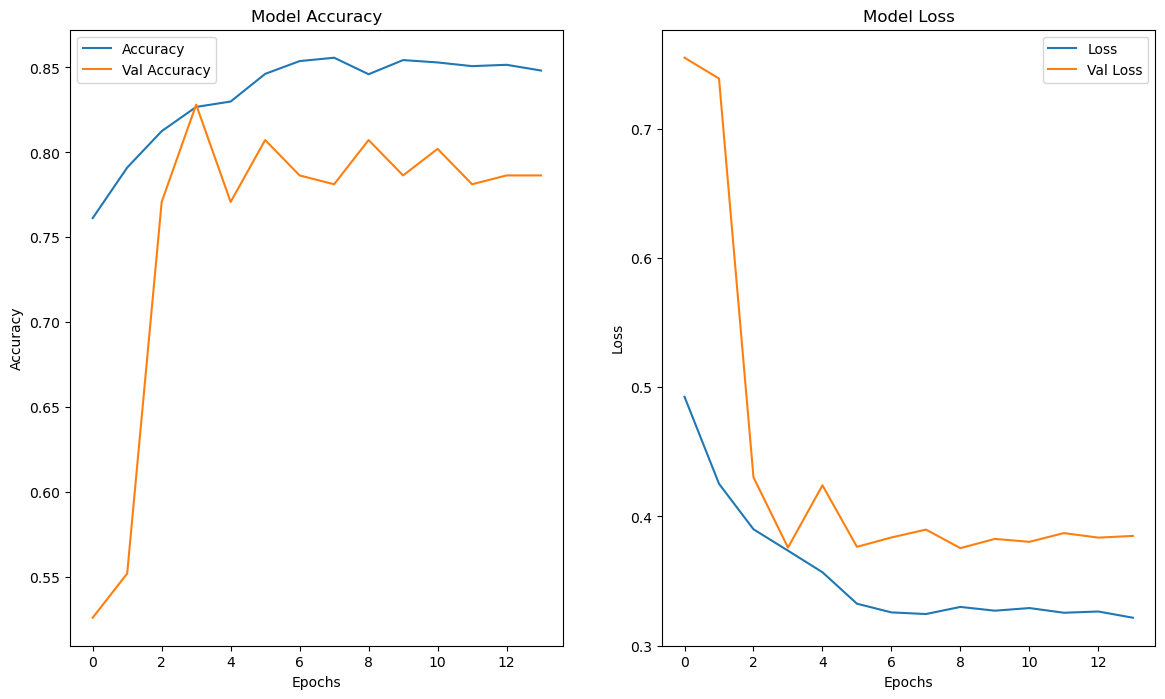

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model5_hist.history['accuracy'])
ax1.plot(model5_hist.history['val_accuracy'])
#ax1.plot(model5_hist.history['recall_7'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy', 'Recall'])
ax1.set_title('Model Accuracy')

ax2.plot(model5_hist.history['loss'])
ax2.plot(model5_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# EfficientNet

EfficientNet is another neural network developed by researchers at Google in 2019. Its different than other convolution neural networks in that it uses something called compound scaling. This scales all three dimensions(number of layers, number of channels, input image size) simultaneously as opposed to individually in other networks. It's aim obviously is to be more efficient than other networks while still obtaining high accuracy.

In [45]:
#Change batch size depending on scenario
b_size = 32

train_data = ImageDataGenerator(rescale=1/255, rotation_range=30, zoom_range=0.25, horizontal_flip=True,
                                width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest' ) #CHANGED FILL_MODE TO CONSTANT TO TEST MODEL, DEFAULT=NEAREST
train_img = train_data.flow_from_directory(directory='../data/train', target_size=(150,150), batch_size=b_size, class_mode='binary', shuffle=True)

val_data = ImageDataGenerator(rescale=1/255)
val_img = val_data.flow_from_directory(directory='../data/val', target_size=(150, 150), batch_size = b_size, class_mode='binary', shuffle=True)

test_data = ImageDataGenerator(rescale=1/255)
test_img = test_data.flow_from_directory(directory='../data/test', target_size=(150, 150), batch_size = b_size, class_mode='binary', shuffle=True)

Found 5040 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
model6 = Sequential()
model6.add(efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(150, 150, 3), pooling='max'))
model6.add(Flatten())
model6.add(Dropout(0.1))
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(1, activation='sigmoid'))
model6.layers[0].trainable = False

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True , patience=5, verbose=1)

optimizer = keras.optimizers.Adam(lr=0.001, clipnorm=1.0)
model6.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])
model6_hist = model6.fit(train_img, epochs=15, steps_per_epoch=5040/b_size, validation_data=val_img, callbacks=[reduce_lr, early_stop])

Epoch 1/15
157/157 [==============================] - 72s 391ms/step - loss: 0.4499 - accuracy: 0.8157 - recall_14: 0.8925 - val_loss: 0.2772 - val_accuracy: 0.8750 - val_recall_14: 0.9271 - lr: 0.0010
Epoch 2/15
158/157 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8750 - recall_14: 0.9282
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
157/157 [==============================] - 60s 379ms/step - loss: 0.2944 - accuracy: 0.8750 - recall_14: 0.9282 - val_loss: 0.3433 - val_accuracy: 0.8281 - val_recall_14: 0.9792 - lr: 0.0010
Epoch 3/15
157/157 [==============================] - 62s 393ms/step - loss: 0.2584 - accuracy: 0.8960 - recall_14: 0.9416 - val_loss: 0.2120 - val_accuracy: 0.9479 - val_recall_14: 0.9375 - lr: 1.0000e-04
Epoch 4/15
158/157 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.8885 - recall_14: 0.9358
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
157/157 [======

In [47]:
model6.evaluate(test_img)

20/20 [==============================] - 5s 216ms/step - loss: 0.3068 - accuracy: 0.8782 - recall_14: 0.9615


[0.30675989389419556, 0.8782051205635071, 0.9615384340286255]

Text(0.5, 1.0, 'Model Loss')

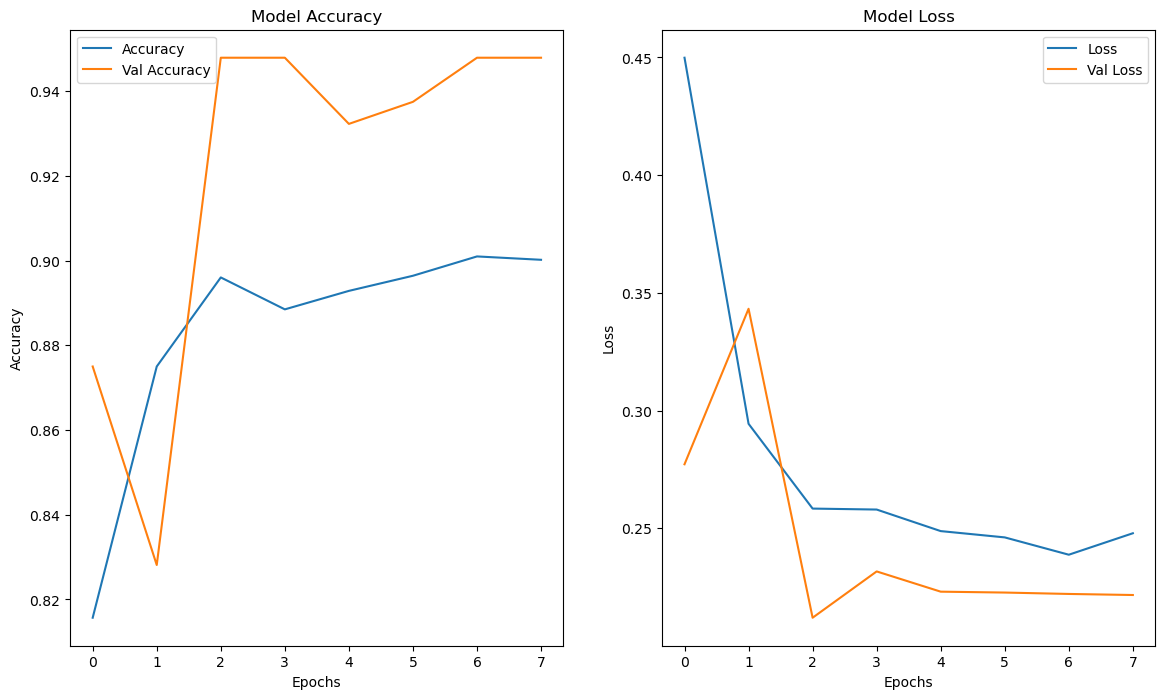

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
ax1.plot(model6_hist.history['accuracy'])
ax1.plot(model6_hist.history['val_accuracy'])
#ax1.plot(model5_hist.history['recall_7'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['Accuracy', 'Val Accuracy', 'Recall'])
ax1.set_title('Model Accuracy')

ax2.plot(model6_hist.history['loss'])
ax2.plot(model6_hist.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(['Loss', 'Val Loss'])
ax2.set_title('Model Loss')

# Grad-CAM Testing

Grad cam is used to visualize where in the picture the model is determining which class it is. Grad cam will apply a heatmap to the picture, which we can then inspect to see if it is working properly. This may be somewhat out of scope for phase 4, and may end up being a feature I implement in phase 5, but I will begin trying to work on it here

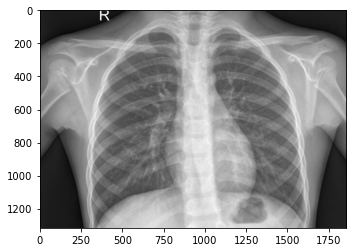

In [135]:
#image = keras.utils.load_img('../data/test/NORMAL/IM-0001-0001.jpeg', target_size=(150,150))
image = keras.preprocessing.image.load_img('../data/test/NORMAL/IM-0001-0001.jpeg')
plt.imshow(image)

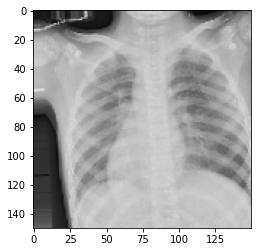

In [185]:
batch=next(train_img)
plt.imshow(batch[0][0])

In [5]:
model_e = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(150,150,3), pooling='max')

In [16]:
[(layer.name, type(layer).__name__) for layer in model_e.layers][-10:]

[('block7b_se_expand', 'Conv2D'),
 ('block7b_se_excite', 'Multiply'),
 ('block7b_project_conv', 'Conv2D'),
 ('block7b_project_bn', 'BatchNormalization'),
 ('block7b_drop', 'FixedDropout'),
 ('block7b_add', 'Add'),
 ('top_conv', 'Conv2D'),
 ('top_bn', 'BatchNormalization'),
 ('top_activation', 'Activation'),
 ('max_pool', 'GlobalMaxPooling2D')]

Much of this code was taken from the Keras website detailing how to implement gradcam

In [70]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

There is an issue with this as creating the gradcam entails getting the last convolutional layer of the model so that the gradcam can use it to make the mappings. However, when we try to remove the final dense layers and try to create our own model, the gradcam can no longer access the last convolutional layer from EfficientNetB4, which is named top_conv. Instead, the entirety of EfficientNetB4 with the dense layers removed is now reffered to as an entire layer. 

1/1 [==============================] - 2s 2s/step
[[ 7.7922516e+00  3.7358704e+00  1.9043884e+01 ...  7.2786613e+00
  -7.3893378e-19 -2.2741349e-30]]
[[0 0 0 ... 0 1 1]]


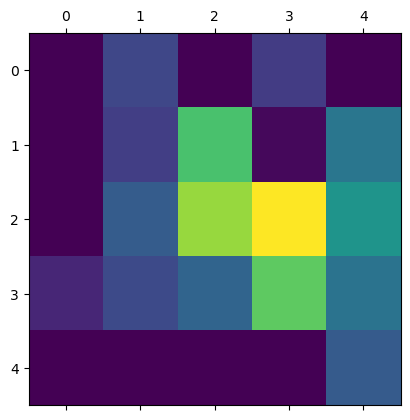

In [73]:
# THIS WONT WORK
#model_ef = Sequential()
model_ef = (efn.EfficientNetB4(input_shape=(150,150,3), include_top=False, weights='imagenet', pooling='max'))
#model_ef.add(Flatten())
#model_ef.add(Dropout(0.1))
#model_ef.add(Dense(128, activation='relu'))
#model_ef.add(Dropout(0.2))
#model_ef.add(Dense(1, activation='sigmoid'))
#model_ef.layers[0].trainable = False

#optimizer = keras.optimizers.Adam(lr=0.001, clipnorm=1.0)
#model_ef.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall()])

img_path = '../data/train/NORMAL/IM-0256-0001.jpeg'
img_size = (150, 150)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.imagenet_utils.decode_predictions
# Prepare image
img_array = get_img_array(img_path, size=img_size)


# Remove last layer's softmax
model_ef.layers[-1].activation = None

# Print what the top predicted class is
preds = model_ef.predict(img_array)
print(preds)
#print("Predicted:", decode_predictions(preds, top=1)[0])
print((preds < 0.5).astype(int))
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model_ef, 'top_conv') #Cannot access top_conv even though it is the last convolutional layer when including custom dense layers

# Display heatmap
plt.matshow(heatmap)
plt.show()

While it does seem to be working, it doesn't seem to be working to well. It is marking empty space on the right as important. The prediction also does not return back a prediction for binary values, instead it is a list of a large amount of values. 

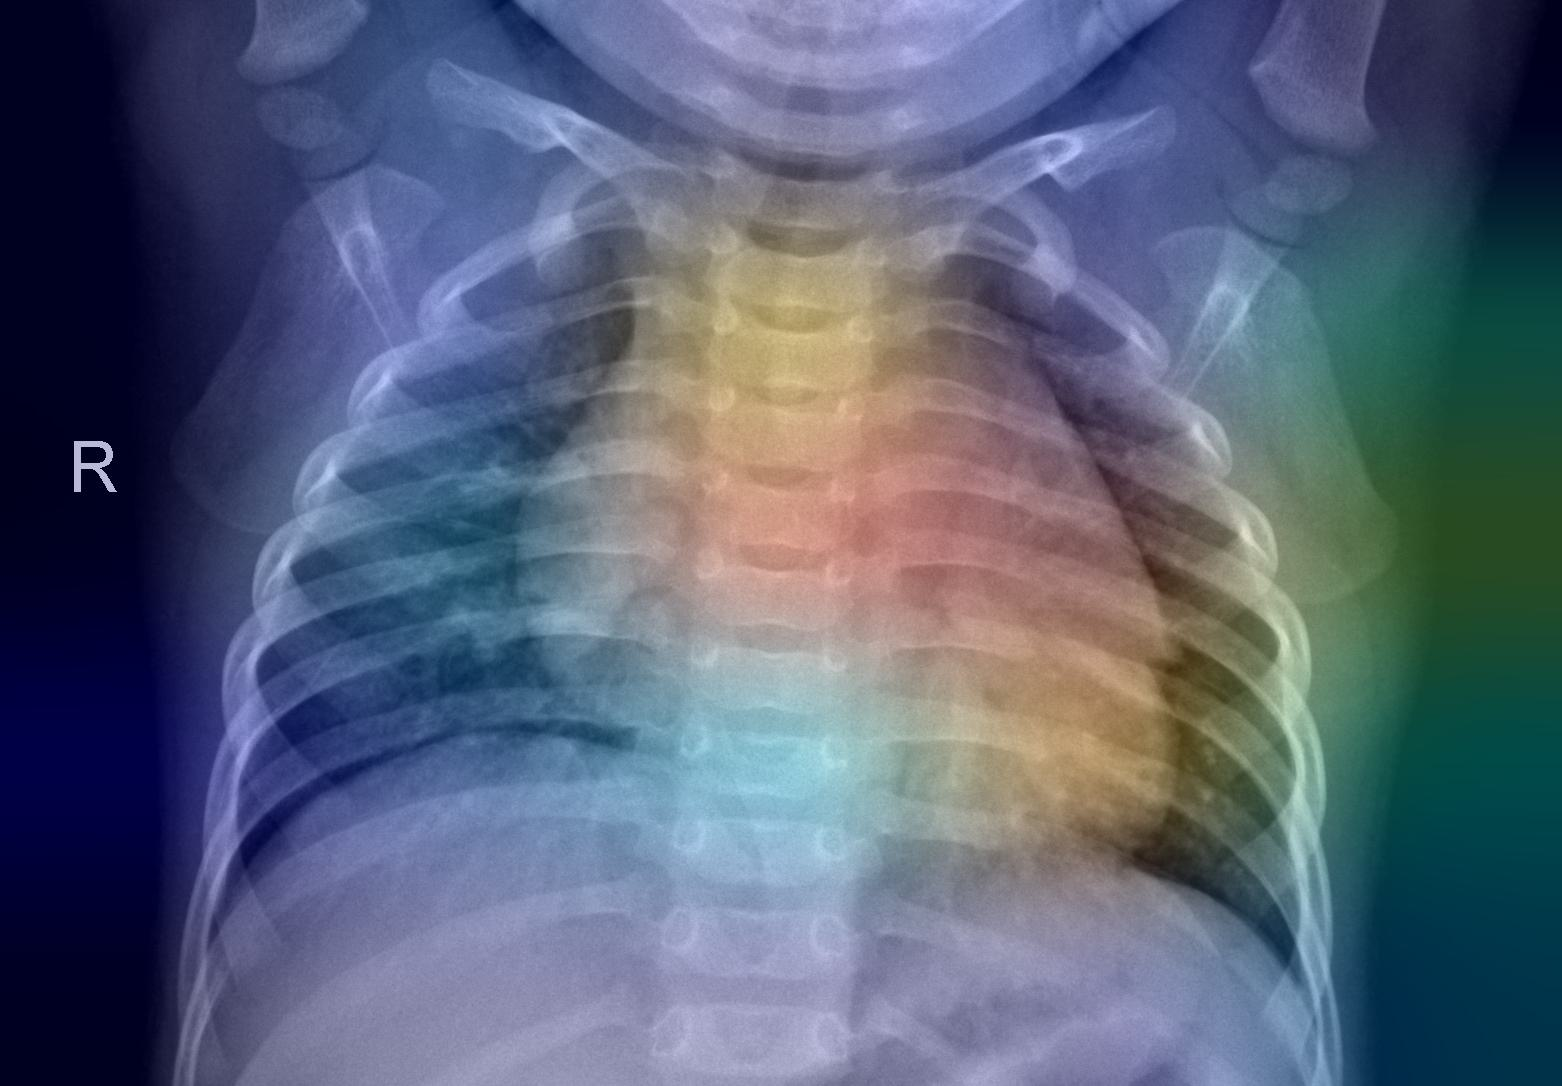

In [75]:
import matplotlib as mpl
from IPython.display import Image, display
def save_and_display_gradcam(img_path, heatmap, cam_path="../images/heatmap.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)